<font color = darkblue size =6.5><center> Duplicate Question Pair  

### Problem statement

    It is a binary classification problem, for a given pair of questions we need to predict if they are duplicate or not. 

### Import Laibraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from nltk.corpus import stopwords
from fuzzywuzzy import fuzz

from bs4 import BeautifulSoup
import re
import time

import warnings
warnings.filterwarnings('ignore')

#### Steps to Perform

Step 1 : Data Analysis, Preprocessing, Model Training, Model Evaluation. (Step 1 - Simple Model.ipynb)

Step 2 : Data Analysis, Preprocessing, Feature Engineering, Model Training, Model Evaluation.
  
Step 3 : Data Analysis, Preprocessing, Advanced Feature Engineering, Model Training, Model Evaluation.

### Data Gathering

In [2]:
df = pd.read_csv('Questions.csv')
print("shape",df.shape)
df.head()

shape (404290, 6)


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [ ]:
# Null values present in dataset
df.isna().sum()

In [ ]:
# Removed these null values
df.dropna(inplace = True)

In [ ]:
# Check for duplicates
df.duplicated().sum()

0    255027
1    149263
Name: is_duplicate, dtype: int64
0    63.080215
1    36.919785
Name: is_duplicate, dtype: float64


<AxesSubplot:>

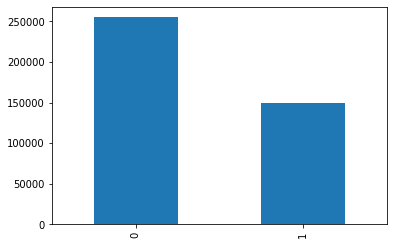

In [4]:
# Distribution of duplicate and non-duplicate questions

print(df['is_duplicate'].value_counts())
print((df['is_duplicate'].value_counts()/df['is_duplicate'].count()) * 100)
df['is_duplicate'].value_counts().plot(kind = 'bar')

In [5]:
# Unique & Repeated questions

qid = pd.Series(df['qid1'].tolist() + df['qid2'].tolist()) # Both the columns are combined together
print('Number of unique questions over 808574 questions :',np.unique(qid).shape[0])
x = qid.value_counts() > 1
print('Number of repeated questions : ',x[x].shape[0]) 

Number of unique questions over 808574 questions : 537933
Number of repeated questions :  111780


In [ ]:
# Repeated questions histogram
# There is a question which repeated 160 times and another repeated 120 times

plt.hist(qid.value_counts().values,bins=160)
plt.xlabel('Charecters in a question')
plt.yscale('log')
plt.show()

### Text Wrangling and Pre-Processing

In [7]:
def preprocess(q):
    q = str(q).lower().strip()
    
    # Replace certain special characters with their string equivalents
    q = q.replace('%', ' percent')
    q = q.replace('$', ' dollar ')
    q = q.replace('₹', ' rupee ')
    q = q.replace('€', ' euro ')
    q = q.replace('@', ' at ')
    
    # The pattern '[math]' appears around 900 times in the whole dataset.
    q = q.replace('[math]', '')
    
    # Replacing some numbers with string equivalents (not perfect, can be done better to account for more cases)
    q = q.replace(',000,000,000 ', 'b ')
    q = q.replace(',000,000 ', 'm ')
    q = q.replace(',000 ', 'k ')
    q = re.sub(r'([0-9]+)000000000', r'\1b', q)
    q = re.sub(r'([0-9]+)000000', r'\1m', q)
    q = re.sub(r'([0-9]+)000', r'\1k', q)
    
    from contractions import contraction
    q_decontracted = []

    for word in q.split():
        if word in contraction:
            word = contraction[word]
        q_decontracted.append(word)
            
    q = ' '.join(q_decontracted)
    q = q.replace("'ve", " have")
    q = q.replace("n't", " not")
    q = q.replace("'re", " are")
    q = q.replace("'ll", " will")

    
    # Removing HTML tags
    
    q = BeautifulSoup(q)
    q = q.get_text()
    
    # Remove punctuations
    pattern = re.compile('\W')
    q = re.sub(pattern, ' ', q).strip()

    
    return q

In [8]:
preprocess("I've already! wasn't <b>done</b>?")

'i have already  was not done'

In [9]:
df['question1'] = df['question1'].apply(preprocess)
df['question2'] = df['question2'].apply(preprocess)

### Feature Engineering
    
    Creating some basics features which can help to improve accuracy : -
        
        1. Length of a question.
        
        2. Words in a question.
        
        3. Common words in a question.
        
        4. Total words in a question.
        
        5. word_share - This is the ratio of the number of common words to the length of the total words in a question.

#### 1. Feature of Length of a question

In [10]:
df['q1_len'] = df['question1'].str.len() 
df['q2_len'] = df['question2'].str.len()

#### 2. Feature of Words in a question.

In [11]:
df['q1_num_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
df['q2_num_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

#### 3. Feature of Common words in a question. 

In [12]:
def common_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return len(w1 & w2)

In [13]:
df['word_common'] = df.apply(common_words, axis=1)

####  4. Feature of Total words in a question.

In [14]:
def total_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return (len(w1) + len(w2))

In [15]:
df['word_total'] = df.apply(total_words, axis=1)

#### 5. Feature of word_share

In [16]:
df['word_share'] = round(df['word_common']/df['word_total'],2)

#### Now there are 13 features

id

qid1 

qid2

question1

question2

is_duplicate

q1_len

q2_len

q1_num_words

q2_num_words

word_common

word_total

word_share

In [19]:
len(df.columns)

13

In [17]:
df.head(3)

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,65,56,14,12,11,23,0.48
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,50,87,12,17,8,26,0.31
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,72,58,14,10,4,24,0.17


### Analysis of Basic Created Features

minimum characters 0
maximum characters 621
average num of characters 58


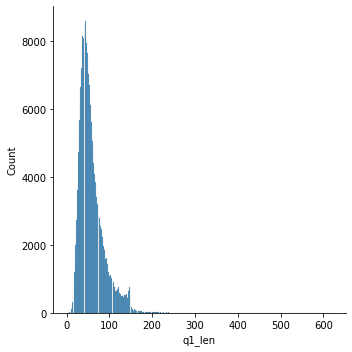

In [20]:
sns.displot(df['q1_len'])
print('minimum characters',df['q1_len'].min())
print('maximum characters',df['q1_len'].max())
print('average num of characters',int(df['q1_len'].mean()))

minimum characters 0
maximum characters 1170
average num of characters 59


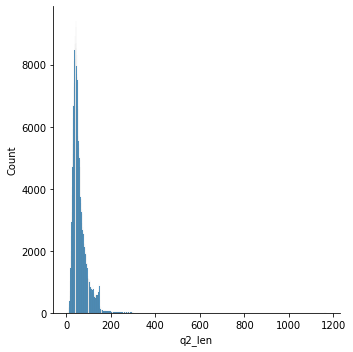

In [21]:
sns.displot(df['q2_len'])
print('minimum characters',df['q2_len'].min())
print('maximum characters',df['q2_len'].max())
print('average num of characters',int(df['q2_len'].mean()))

minimum words 1
maximum words 147
average num of words 11


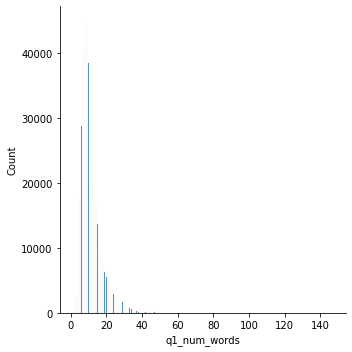

In [22]:
sns.displot(df['q1_num_words'])
print('minimum words',df['q1_num_words'].min())
print('maximum words',df['q1_num_words'].max())
print('average num of words',int(df['q1_num_words'].mean()))

minimum words 1
maximum words 270
average num of words 11


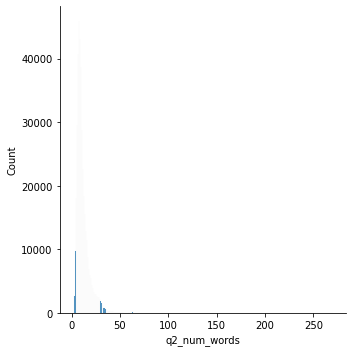

In [23]:
sns.displot(df['q2_num_words'])
print('minimum words',df['q2_num_words'].min())
print('maximum words',df['q2_num_words'].max())
print('average num of words',int(df['q2_num_words'].mean()))

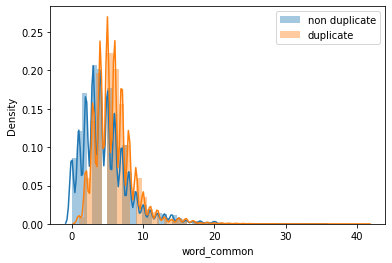

In [24]:
# common words
sns.distplot(df[df['is_duplicate'] == 0]['word_common'],label='non duplicate')
sns.distplot(df[df['is_duplicate'] == 1]['word_common'],label='duplicate')
plt.legend()
plt.show()

# No conclusion all the questions are overlaping.

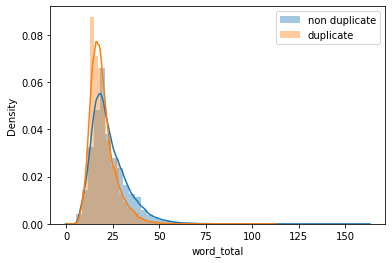

In [25]:
# total words
sns.distplot(df[df['is_duplicate'] == 0]['word_total'],label='non duplicate')
sns.distplot(df[df['is_duplicate'] == 1]['word_total'],label='duplicate')
plt.legend()
plt.show()

# if the words are greater than 25 then there will be low posibility of question to be duplicated.

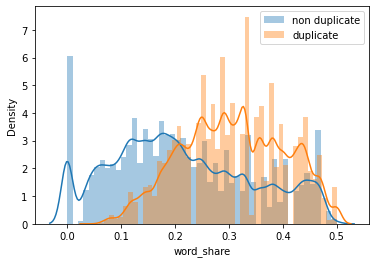

In [26]:
# word share
sns.distplot(df[df['is_duplicate'] == 0]['word_share'],label='non duplicate')
sns.distplot(df[df['is_duplicate'] == 1]['word_share'],label='duplicate')
plt.legend()
plt.show()

# If the value of word_share is <= 0.2 then there will be high probability of non-duplication of question and if greater
# then high probability of duplication of question.

                                            ♦️♦️♦️ 
    Minimal imporvement done while evaluating model on this basic features, Therefore needs to create some 
    extra features by doing Advanced Feature Engineering to improve model performance.
                                            ♦️♦️♦️

### Advanced Feature Engineering

### 1. Token Features

cwc_min: This is the ratio of the number of common words to the length of the smaller question

cwc_max: This is the ratio of the number of common words to the length of the larger question

csc_min: This is the ratio of the number of common stop words to the smaller stop word count among the two questions

csc_max: This is the ratio of the number of common stop words to the larger stop word count among the two questions

ctc_min: This is the ratio of the number of common tokens to the smaller token count among the two questions

ctc_max: This is the ratio of the number of common tokens to the larger token count among the two questions

last_word_eq: 1 if the last word in the two questions is same, 0 otherwise

first_word_eq: 1 if the first word in the two questions is same, 0 otherwise


###  2. Fuzzy Features

fuzz_ratio: fuzz_ratio score from fuzzywuzzy

fuzz_partial_ratio: fuzz_partial_ratio from fuzzywuzzy

token_sort_ratio: token_sort_ratio from fuzzywuzzy

token_set_ratio: token_set_ratio from fuzzywuzzy


#### 1. Token Features

In [28]:
def fetch_token_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    SAFE_DIV = 0.0001 

    STOP_WORDS = stopwords.words("english")
    
    token_features = [0.0]*8
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features

    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    return token_features

In [29]:
token_features = df.apply(fetch_token_features, axis=1)

df["cwc_min"]       = list(map(lambda x: x[0], token_features))
df["cwc_max"]       = list(map(lambda x: x[1], token_features))
df["csc_min"]       = list(map(lambda x: x[2], token_features))
df["csc_max"]       = list(map(lambda x: x[3], token_features))
df["ctc_min"]       = list(map(lambda x: x[4], token_features))
df["ctc_max"]       = list(map(lambda x: x[5], token_features))
df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
df["first_word_eq"] = list(map(lambda x: x[7], token_features))

#### 2. Fuzzy Features

In [30]:
def fetch_fuzzy_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    fuzzy_features = [0.0]*4
    
    # fuzz_ratio
    fuzzy_features[0] = fuzz.QRatio(q1, q2)

    # fuzz_partial_ratio
    fuzzy_features[1] = fuzz.partial_ratio(q1, q2)

    # token_sort_ratio
    fuzzy_features[2] = fuzz.token_sort_ratio(q1, q2)

    # token_set_ratio
    fuzzy_features[3] = fuzz.token_set_ratio(q1, q2)

    return fuzzy_features

In [31]:
fuzzy_features = df.apply(fetch_fuzzy_features, axis=1)

df['fuzz_ratio'] = list(map(lambda x: x[0], fuzzy_features))
df['fuzz_partial_ratio'] = list(map(lambda x: x[1], fuzzy_features))
df['token_sort_ratio'] = list(map(lambda x: x[2], fuzzy_features))
df['token_set_ratio'] = list(map(lambda x: x[3], fuzzy_features))

print(df.shape)
df.T

(404290, 25)


,0,1,2,3,4,5,6,7,8,9,...,404280,404281,404282,404283,404284,404285,404286,404287,404288,404289
id,0,1,2,3,4,5,6,7,8,9,...,404280,404281,404282,404283,404284,404285,404286,404287,404288,404289
qid1,1,3,5,7,9,11,13,15,17,19,...,537922,99131,1931,537924,537926,433578,18840,537928,537930,537932
qid2,2,4,6,8,10,12,14,16,18,20,...,537923,81495,16773,537925,537927,379845,155606,537929,537931,537933
question1,what is the step by step guide to invest in sh...,what is the story of kohinoor koh i noor dia...,how can i increase the speed of my internet co...,why am i mentally very lonely how can i solve it,which one dissolve in water quikly sugar salt...,astrology i am a capricorn sun cap moon and c...,should i buy tiago,how can i be a good geologist,when do you use シ instead of し,motorola company can i hack my charter moto...,...,what are some outfit ideas to wear to a frat p...,why is manaphy childish in pokémon ranger and ...,how does a long distance relationship work,what do you think of the removal of the magsaf...,what does jainism say about homosexuality,how many keywords are there in the racket prog...,do you believe there is life after death,what is one coin,what is the approx annual cost of living while...,what is like to have sex with cousin
question2,what is the step by step guide to invest in sh...,what would happen if the indian government sto...,how can internet speed be increased by hacking...,find the remainder when 23 24 math is divi...,which fish would survive in salt water,i am a triple capricorn sun moon and ascenda...,what keeps childern active and far from phone ...,what should i do to be a great geologist,when do you use instead of and,how do i hack motorola dcx3400 for free internet,...,what are some outfit ideas wear to a frat them...,why is manaphy annoying in pokemon ranger and ...,how are long distance relationships maintained,what will the cpu upgrade to the 2016 apple ma...,what does jainism say about gays and homosexua...,how many keywords are there in perl programmin...,is it true that there is life after death,what is this coin,i am having little hairfall problem but i want...,what is it like to have sex with your cousin
is_duplicate,0,0,0,0,0,1,0,1,0,0,...,1,1,1,0,1,0,1,0,0,0
q1_len,65,50,72,49,75,85,18,29,30,59,...,50,67,42,87,41,84,40,16,93,36
q2_len,56,87,58,58,38,90,61,40,35,48,...,54,67,46,60,50,78,41,17,126,44
q1_num_words,14,12,14,12,15,20,4,7,8,12,...,11,13,7,17,6,14,8,4,18,8
q2_num_words,12,17,10,16,7,20,11,9,12,9,...,11,13,6,12,8,13,9,4,27,10


#### Now there are Total 25 new features

13 (previous) + 12 (new)


### Analysis of Advanced Created Features

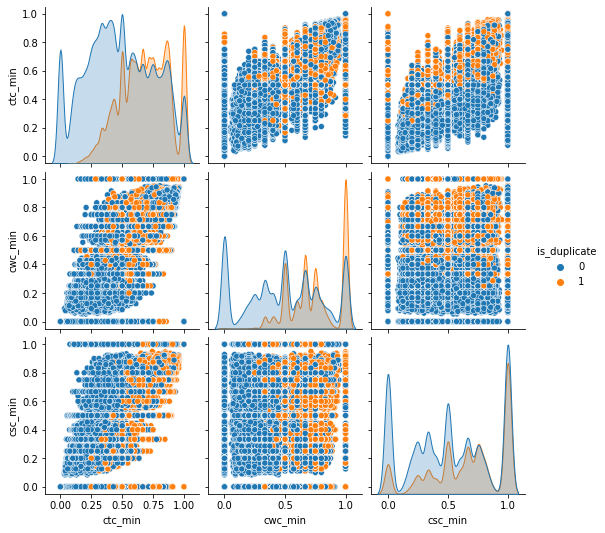

In [33]:
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'is_duplicate']],hue='is_duplicate')

# all the features 'ctc_min', 'cwc_min', 'csc_min' are important.

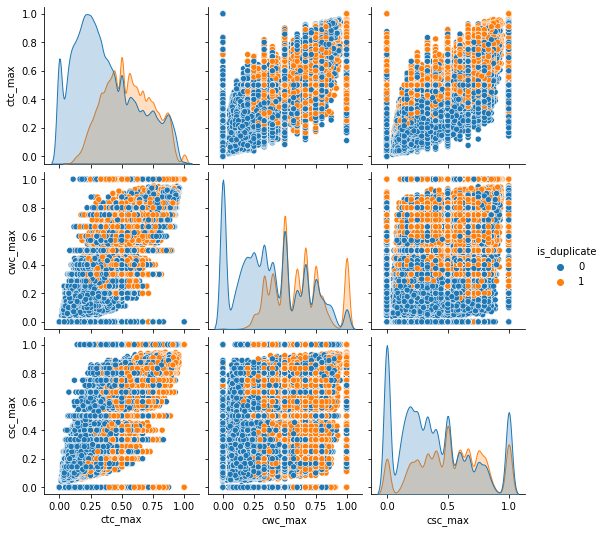

In [34]:
sns.pairplot(df[['ctc_max', 'cwc_max', 'csc_max', 'is_duplicate']],hue='is_duplicate')
# Here also all the features are important because they are not overloping.

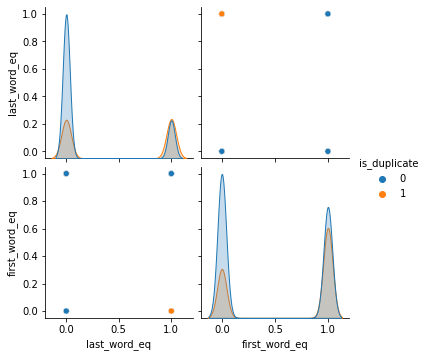

In [35]:
sns.pairplot(df[['last_word_eq', 'first_word_eq', 'is_duplicate']],hue='is_duplicate')

# If last word or first word is not matching then then there will be high probability of questin isn't duplicate

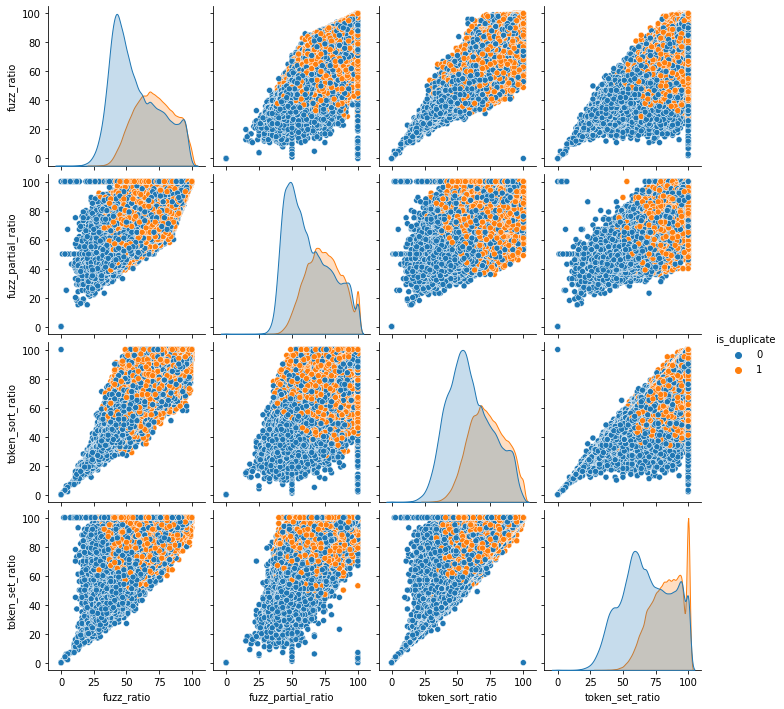

In [36]:
sns.pairplot(df[['fuzz_ratio', 'fuzz_partial_ratio','token_sort_ratio','token_set_ratio', 'is_duplicate']],hue='is_duplicate')
# Here also all the features are important

In [48]:
# Created new_df for sample of 30000 questions.

new_df = df.sample(30000)
print("shape",new_df.shape)
new_df.head()

shape (30000, 25)


,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,...,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
243152,243152,355539,355540,where and how did the idea of vampires and lyc...,are vampires real if not where and how did t...,1,59,75,11,16,...,0.999983,0.666659,0.818174,0.642853,1.0,0.0,72,90,79,93
322297,322297,448091,175970,what is a ping in quora,what is ping,0,23,12,6,3,...,0.999950,0.499988,0.999967,0.499992,0.0,1.0,69,83,69,100
353329,353329,22805,482361,should i prepare for neet 2017 again,how can i prepare for neet 2017 from now onwards,0,36,48,7,10,...,0.499988,0.333328,0.714276,0.499995,0.0,0.0,67,75,62,78
294203,294203,36790,94795,what are the best digital marketing agencies i...,what is the best digital marketing agency in i...,1,53,50,9,9,...,0.749981,0.749981,0.777769,0.777769,1.0,1.0,91,88,89,93
31363,31363,17440,57829,how is life in dubai,how is life in dubai,1,20,20,5,5,...,0.999967,0.999967,0.999980,0.999980,1.0,1.0,100,100,100,100


In [49]:
# Created ques_df which contain all the questions from question1 and question2

ques_df = new_df[['question1','question2']]
questions = list(ques_df['question1']) + list(ques_df['question2'])

new_features = new_df.drop(columns=['id','qid1','qid2','question1','question2'])
print(new_features.shape)
new_features.head()

(30000, 20)


,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
243152,1,59,75,11,16,9,24,0.38,0.749981,0.749981,0.999983,0.666659,0.818174,0.642853,1.0,0.0,72,90,79,93
322297,0,23,12,6,3,3,9,0.33,0.999900,0.499975,0.999950,0.499988,0.999967,0.499992,0.0,1.0,69,83,69,100
353329,0,36,48,7,10,5,17,0.29,0.999967,0.749981,0.499988,0.333328,0.714276,0.499995,0.0,0.0,67,75,62,78
294203,1,53,50,9,9,7,18,0.39,0.799984,0.799984,0.749981,0.749981,0.777769,0.777769,1.0,1.0,91,88,89,93
31363,1,20,20,5,5,5,10,0.50,0.999950,0.999950,0.999967,0.999967,0.999980,0.999980,1.0,1.0,100,100,100,100


### Vectorization

In [50]:
# CountVectorizer performing well as compare to TfidfVectorizer

cv = CountVectorizer(max_features=3000)
q1_arr, q2_arr = np.vsplit(cv.fit_transform(questions).toarray(),2)

In [51]:
temp_df1 = pd.DataFrame(q1_arr, index= ques_df.index)
temp_df2 = pd.DataFrame(q2_arr, index= ques_df.index)
temp_df = pd.concat([temp_df1, temp_df2], axis=1)
temp_df.shape

(30000, 6000)

In [52]:
final_df = pd.concat([new_features, temp_df], axis=1)
print(final_df.shape)
final_df.head()

(30000, 6020)


,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share,cwc_min,cwc_max,...,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
243152,1,59,75,11,16,9,24,0.38,0.749981,0.749981,...,0,0,0,0,0,0,0,0,0,0
322297,0,23,12,6,3,3,9,0.33,0.999900,0.499975,...,0,0,0,0,0,0,0,0,0,0
353329,0,36,48,7,10,5,17,0.29,0.999967,0.749981,...,0,0,0,0,0,0,0,0,0,0
294203,1,53,50,9,9,7,18,0.39,0.799984,0.799984,...,0,0,0,0,0,0,0,0,0,0
31363,1,20,20,5,5,5,10,0.50,0.999950,0.999950,...,0,0,0,0,0,0,0,0,0,0


In [53]:
final_df = final_df.astype(np.uint8)

# used astype(np.uint8) to avoid MemoryError: Unable to allocate 283. GiB for an array with shape (156816, 36, 53806)

### Train_Test_Split

In [54]:
x_train,x_test,y_train,y_test = train_test_split(final_df.iloc[:,1:].values,final_df.iloc[:,0].values,test_size=0.2,random_state=1)

### Evaluation
    
    1. RandomForestClassifier

In [55]:
start_time = time.time()

rf = RandomForestClassifier()
rf.fit(x_train,y_train)
y_pred = rf.predict(x_test)
print(accuracy_score(y_test,y_pred))

print('confusion_matrix \n',confusion_matrix(y_test,y_pred))

end_time = time.time()

print(f"Time taken for execution : {end_time - start_time} Seconds")

0.79
confusion_matrix 
 [[3309  479]
 [ 781 1431]]
Time taken for execution : 118.11184287071228 Seconds


### Evaluation
    
    2. MultinomialNB

In [56]:
start_time = time.time()

mnb = MultinomialNB()
mnb.fit(x_train,y_train)
y_pred = mnb.predict(x_test)
print(accuracy_score(y_test,y_pred))

print('confusion_matrix \n',confusion_matrix(y_test,y_pred))

end_time = time.time()

print(f"Time taken for execution : {end_time - start_time} Seconds")

0.673
confusion_matrix 
 [[2310 1478]
 [ 484 1728]]
Time taken for execution : 2.230985641479492 Seconds


### Evaluation

    3. BernoulliNB

In [57]:
start_time = time.time()

bnb = BernoulliNB()
bnb.fit(x_train,y_train)
y_pred = bnb.predict(x_test)
print(accuracy_score(y_test,y_pred))

print('confusion_matrix \n',confusion_matrix(y_test,y_pred))

end_time = time.time()

print(f"Time taken for execution : {end_time - start_time} Seconds")

0.7201666666666666
confusion_matrix 
 [[2868  920]
 [ 759 1453]]
Time taken for execution : 2.5701279640197754 Seconds


### After Performing All the Steps

#### Step 1 : Analysis of data, preprocessing, Model Training, Evaluation

        RandomForestClassifier = 0.7574
        MultinomialNB = 0.7121
        BernoulliNB = 0.7024
    
#### Step 2 : Analysis of data, preprocessing, Basic Feature Engineering, Model Training, Evaluation

    RandomForestClassifier = 0.7595
    MultinomialNB = 0.7413
    BernoulliNB = 0.7045
    
#### Step 3 : Analysis of data, preprocessing, Advanced Feature Engineering, Model Training, Evaluation

    RandomForestClassifier = 0.7918
    MultinomialNB = 0.673
    BernoulliNB = 0.7201

# Flask

In [58]:
def preprocess(q):
    q = str(q).lower().strip()
    
    # Replace certain special characters with their string equivalents
    q = q.replace('%', ' percent')
    q = q.replace('$', ' dollar ')
    q = q.replace('₹', ' rupee ')
    q = q.replace('€', ' euro ')
    q = q.replace('@', ' at ')
    
    # The pattern '[math]' appears around 900 times in the whole dataset.
    q = q.replace('[math]', '')
    
    # Replacing some numbers with string equivalents (not perfect, can be done better to account for more cases)
    q = q.replace(',000,000,000 ', 'b ')
    q = q.replace(',000,000 ', 'm ')
    q = q.replace(',000 ', 'k ')
    q = re.sub(r'([0-9]+)000000000', r'\1b', q)
    q = re.sub(r'([0-9]+)000000', r'\1m', q)
    q = re.sub(r'([0-9]+)000', r'\1k', q)
    
    from contractions import contraction
    q_decontracted = []

    for word in q.split():
        if word in contraction:
            word = contraction[word]
        q_decontracted.append(word)
            
    q = ' '.join(q_decontracted)
    q = q.replace("'ve", " have")
    q = q.replace("n't", " not")
    q = q.replace("'re", " are")
    q = q.replace("'ll", " will")

    
    # Removing HTML tags
    
    q = BeautifulSoup(q)
    q = q.get_text()
    
    # Remove punctuations
    pattern = re.compile('\W')
    q = re.sub(pattern, ' ', q).strip()

    
    return q

def test_common_words(q1,q2):
    w1 = set(map(lambda word: word.lower().strip(), q1.split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), q2.split(" ")))    
    return len(w1 & w2)

def test_total_words(q1,q2):
    w1 = set(map(lambda word: word.lower().strip(), q1.split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), q2.split(" ")))    
    return (len(w1) + len(w2))

def test_fetch_token_features(q1,q2):
    
    SAFE_DIV = 0.0001 

    STOP_WORDS = stopwords.words("english")
    
    token_features = [0.0]*8
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features

    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    return token_features

def test_fetch_fuzzy_features(q1,q2):
    
    fuzzy_features = [0.0]*4
    
    # fuzz_ratio
    fuzzy_features[0] = fuzz.QRatio(q1, q2)

    # fuzz_partial_ratio
    fuzzy_features[1] = fuzz.partial_ratio(q1, q2)

    # token_sort_ratio
    fuzzy_features[2] = fuzz.token_sort_ratio(q1, q2)

    # token_set_ratio
    fuzzy_features[3] = fuzz.token_set_ratio(q1, q2)

    return fuzzy_features


def query_point_creator(q1,q2):
    
    input_query = []
    
    # preprocess
    q1 = preprocess(q1)
    q2 = preprocess(q2)
    
    # fetch basic features
    input_query.append(len(q1))
    input_query.append(len(q2))
    
    input_query.append(len(q1.split(" ")))
    input_query.append(len(q2.split(" ")))
    
    input_query.append(test_common_words(q1,q2))
    input_query.append(test_total_words(q1,q2))
    input_query.append(round(test_common_words(q1,q2)/test_total_words(q1,q2),2))
    
    # fetch token features
    token_features = test_fetch_token_features(q1,q2)
    input_query.extend(token_features)
    
    # fetch fuzzy features
    fuzzy_features = test_fetch_fuzzy_features(q1,q2)
    input_query.extend(fuzzy_features)
    
    # bow feature for q1
    q1_bow = cv.transform([q1]).toarray()
    
    # bow feature for q2
    q2_bow = cv.transform([q2]).toarray()
    
    
    
    return np.hstack((np.array(input_query).reshape(1,19),q1_bow,q2_bow))

In [74]:
# Not duplicate

q1, q2 = df['question1'][14], df['question2'][14] 

print(q1,'\n', q2,'\n')

q1, q2 = df['question1'][26], df['question2'][26] 

print(q1,'\n', q2,'\n')
print('prediction : ',rf.predict(query_point_creator(q1,q_22))[0])
print('prediction : ',rf.predict(query_point_creator(q1,q2))[0])

what are the laws to change your status from a student visa to a green card in the us  how do they compare to the immigration laws in canada 
 what are the laws to change your status from a student visa to a green card in the us  how do they compare to the immigration laws in japan 

what is web application 
 what is the web application framework 

prediction :  0
prediction :  0


In [72]:
# Duplicate

eleven, eleven1 = df['question1'][11], df['question2'][11]
print(eleven,'\n', eleven1)

print()

seven, seven1 = df['question1'][7], df['question2'][7]
print(seven,'\n', seven1,'\n')

print('prediction : ',rf.predict(query_point_creator(eleven,eleven1))[0])
print('prediction : ',rf.predict(query_point_creator(seven,seven1))[0])

how do i read and find my youtube comments 
 how can i see all my youtube comments

how can i be a good geologist 
 what should i do to be a great geologist 

prediction :  1
prediction :  1


In [66]:
import pickle

pickle.dump(rf,open('model.pkl','wb'))
pickle.dump(cv,open('cv.pkl','wb'))